## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp005'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

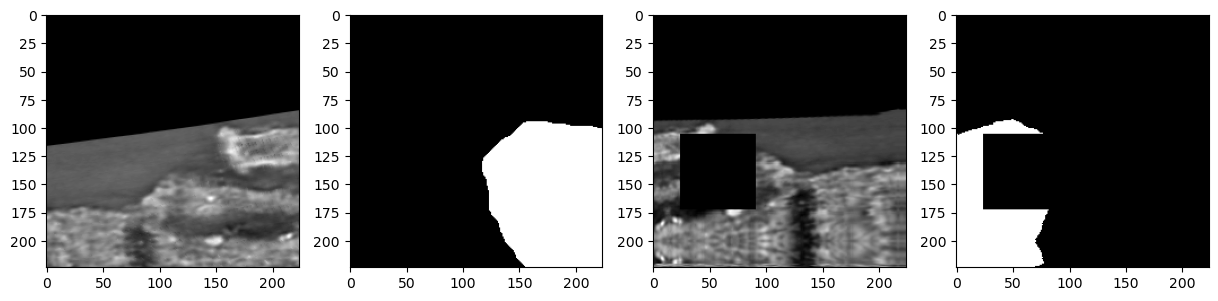

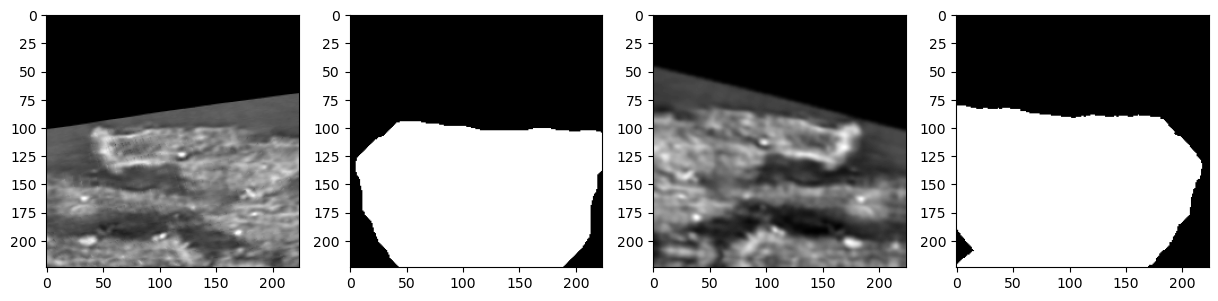

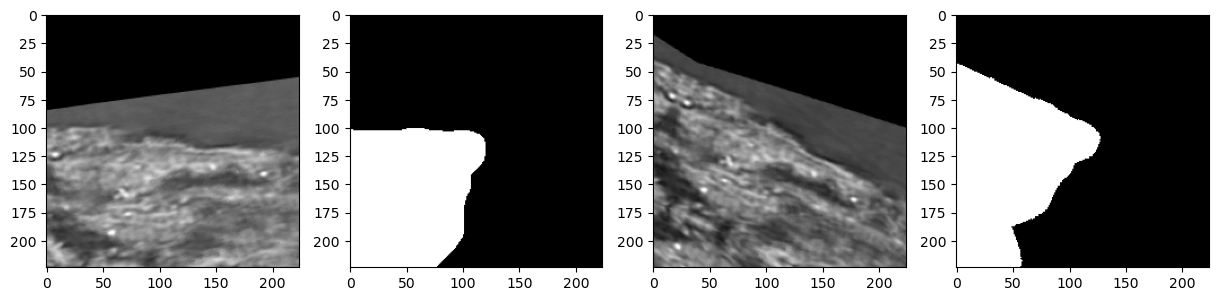

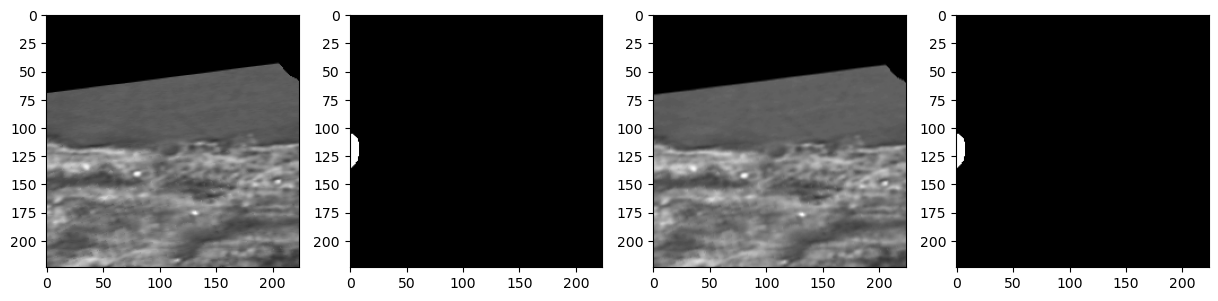

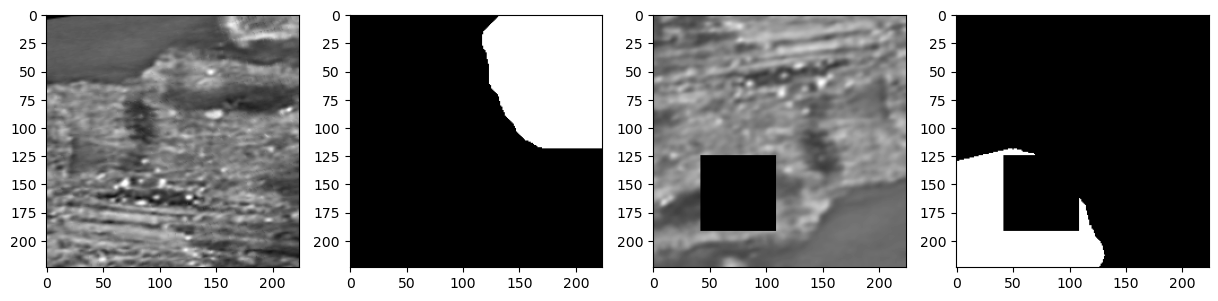

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48110

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14220894527340652
th: 0.15, fbeta: 0.18003568606419446
th: 0.2, fbeta: 0.22224126265701818
th: 0.25, fbeta: 0.23517334102809778
th: 0.3, fbeta: 0.24617663062667094
th: 0.35, fbeta: 0.25486081006636296
th: 0.4, fbeta: 0.2542576135246923
th: 0.45, fbeta: 0.23230973278862757


best_th: 0.35, fbeta: 0.25486081006636296
Epoch 1 - avg_train_loss: 0.4246  avg_val_loss: 0.3951  time: 164s
Epoch 1 - avgScore: 0.2549
Epoch 1 - Save Best Score: 0.2549 Model
Epoch 1 - Save Best Loss: 0.3951 Model


th: 0.5, fbeta: 0.1810577666605701


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14441428654397404
th: 0.15, fbeta: 0.23460871161158464
th: 0.2, fbeta: 0.2697822867536601
th: 0.25, fbeta: 0.2954455595393443
th: 0.3, fbeta: 0.30503110938727535
th: 0.35, fbeta: 0.2842643282179008
th: 0.4, fbeta: 0.23118624931797113
th: 0.45, fbeta: 0.16297670770063533


best_th: 0.3, fbeta: 0.30503110938727535
Epoch 2 - avg_train_loss: 0.3262  avg_val_loss: 0.3527  time: 167s
Epoch 2 - avgScore: 0.3050
Epoch 2 - Save Best Score: 0.3050 Model
Epoch 2 - Save Best Loss: 0.3527 Model


th: 0.5, fbeta: 0.09860945908990935


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.34611023693240683
th: 0.15, fbeta: 0.32778543250402914
th: 0.2, fbeta: 0.27822669859872734
th: 0.25, fbeta: 0.2200768679071937
th: 0.3, fbeta: 0.16362570467326923
th: 0.35, fbeta: 0.11804236544773251
th: 0.4, fbeta: 0.0840177427327105
th: 0.45, fbeta: 0.0582474091083746


best_th: 0.1, fbeta: 0.34611023693240683
Epoch 3 - avg_train_loss: 0.2350  avg_val_loss: 0.3523  time: 164s
Epoch 3 - avgScore: 0.3461
Epoch 3 - Save Best Score: 0.3461 Model
Epoch 3 - Save Best Loss: 0.3523 Model


th: 0.5, fbeta: 0.03942551293016747


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36517656426117273
th: 0.15, fbeta: 0.37611401569017133
th: 0.2, fbeta: 0.3598556881157831
th: 0.25, fbeta: 0.321028263525984
th: 0.3, fbeta: 0.2770521751555636
th: 0.35, fbeta: 0.23437429436566978
th: 0.4, fbeta: 0.19640474720711706
th: 0.45, fbeta: 0.1626395608262473


best_th: 0.15, fbeta: 0.37611401569017133
Epoch 4 - avg_train_loss: 0.1944  avg_val_loss: 0.3715  time: 164s
Epoch 4 - avgScore: 0.3761
Epoch 4 - Save Best Score: 0.3761 Model
Epoch 4 - Save Best Loss: 0.3715 Model


th: 0.5, fbeta: 0.13073770485143307


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36676150576148203
th: 0.15, fbeta: 0.38025628252471594
th: 0.2, fbeta: 0.37786999690439427
th: 0.25, fbeta: 0.37195575697112965
th: 0.3, fbeta: 0.36109228766624213
th: 0.35, fbeta: 0.3477249173927329
th: 0.4, fbeta: 0.32961325214173975
th: 0.45, fbeta: 0.3065288410163687


best_th: 0.15, fbeta: 0.38025628252471594
Epoch 5 - avg_train_loss: 0.1786  avg_val_loss: 0.3725  time: 164s
Epoch 5 - avgScore: 0.3803
Epoch 5 - Save Best Score: 0.3803 Model
Epoch 5 - Save Best Loss: 0.3725 Model


th: 0.5, fbeta: 0.27849662781559775


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3459541627854286
th: 0.15, fbeta: 0.30400866546641153
th: 0.2, fbeta: 0.24933119611129204
th: 0.25, fbeta: 0.18196460642913326
th: 0.3, fbeta: 0.13133330617957376
th: 0.35, fbeta: 0.09549239445287422
th: 0.4, fbeta: 0.06679263512612305
th: 0.45, fbeta: 0.04366102870002731


best_th: 0.1, fbeta: 0.3459541627854286
Epoch 6 - avg_train_loss: 0.1653  avg_val_loss: 0.4485  time: 164s
Epoch 6 - avgScore: 0.3460


th: 0.5, fbeta: 0.025639961603562786


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3783308380711011
th: 0.15, fbeta: 0.3797716218626893
th: 0.2, fbeta: 0.35620671742171156
th: 0.25, fbeta: 0.328338127019587
th: 0.3, fbeta: 0.29850861143356294
th: 0.35, fbeta: 0.26629913539770544
th: 0.4, fbeta: 0.23254970466942698
th: 0.45, fbeta: 0.19727472509265742


best_th: 0.15, fbeta: 0.3797716218626893
Epoch 7 - avg_train_loss: 0.1510  avg_val_loss: 0.4515  time: 165s
Epoch 7 - avgScore: 0.3798


th: 0.5, fbeta: 0.164721757029113


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3495543305376052
th: 0.15, fbeta: 0.34228220877926097
th: 0.2, fbeta: 0.32951143544238054
th: 0.25, fbeta: 0.3108183997085703
th: 0.3, fbeta: 0.2903384307296465
th: 0.35, fbeta: 0.2694106416291981
th: 0.4, fbeta: 0.2469210525859697
th: 0.45, fbeta: 0.22444050397835022


best_th: 0.1, fbeta: 0.3495543305376052
Epoch 8 - avg_train_loss: 0.1419  avg_val_loss: 0.4988  time: 164s
Epoch 8 - avgScore: 0.3496


th: 0.5, fbeta: 0.2010393622251305


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.346222080224981
th: 0.15, fbeta: 0.34120989371094707
th: 0.2, fbeta: 0.3309593857105149
th: 0.25, fbeta: 0.3131518371914499
th: 0.3, fbeta: 0.2915239097663518
th: 0.35, fbeta: 0.26576947714405746
th: 0.4, fbeta: 0.23458527076598992
th: 0.45, fbeta: 0.20198912296776483


best_th: 0.1, fbeta: 0.346222080224981
Epoch 9 - avg_train_loss: 0.1331  avg_val_loss: 0.4746  time: 163s
Epoch 9 - avgScore: 0.3462


th: 0.5, fbeta: 0.17068897127828234


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3866310307336981
th: 0.15, fbeta: 0.3899232560494799
th: 0.2, fbeta: 0.3834978215036873
th: 0.25, fbeta: 0.37409889919216593
th: 0.3, fbeta: 0.3612692154625977
th: 0.35, fbeta: 0.34746934142807434
th: 0.4, fbeta: 0.33106833027997856
th: 0.45, fbeta: 0.31117204044569485


best_th: 0.15, fbeta: 0.3899232560494799
Epoch 10 - avg_train_loss: 0.1254  avg_val_loss: 0.5401  time: 162s
Epoch 10 - avgScore: 0.3899
Epoch 10 - Save Best Score: 0.3899 Model
Epoch 10 - Save Best Loss: 0.5401 Model


th: 0.5, fbeta: 0.2884033532861453


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3401629704586214
th: 0.15, fbeta: 0.32033472713219513
th: 0.2, fbeta: 0.3000799343467625
th: 0.25, fbeta: 0.27947027502163835
th: 0.3, fbeta: 0.2536481496978426
th: 0.35, fbeta: 0.22593658255170307
th: 0.4, fbeta: 0.19631115774130453
th: 0.45, fbeta: 0.16649622278227785


best_th: 0.1, fbeta: 0.3401629704586214
Epoch 11 - avg_train_loss: 0.1165  avg_val_loss: 0.5956  time: 164s
Epoch 11 - avgScore: 0.3402


th: 0.5, fbeta: 0.13700894627170035


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32114649028029857
th: 0.15, fbeta: 0.3013101316245222
th: 0.2, fbeta: 0.2787690003319662
th: 0.25, fbeta: 0.25291757619648053
th: 0.3, fbeta: 0.22655377023864512
th: 0.35, fbeta: 0.20103143532995169
th: 0.4, fbeta: 0.17467156069629414
th: 0.45, fbeta: 0.14874796384820507


best_th: 0.1, fbeta: 0.32114649028029857
Epoch 12 - avg_train_loss: 0.1088  avg_val_loss: 0.6141  time: 164s
Epoch 12 - avgScore: 0.3211


th: 0.5, fbeta: 0.12394330602738517


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34578619554623197
th: 0.15, fbeta: 0.34810816206360295
th: 0.2, fbeta: 0.3433671891071787
th: 0.25, fbeta: 0.334963657777634
th: 0.3, fbeta: 0.32571538632710145
th: 0.35, fbeta: 0.3135098597617066
th: 0.4, fbeta: 0.29939419571931586
th: 0.45, fbeta: 0.2817724446281123


best_th: 0.15, fbeta: 0.34810816206360295
Epoch 13 - avg_train_loss: 0.0997  avg_val_loss: 0.5548  time: 163s
Epoch 13 - avgScore: 0.3481


th: 0.5, fbeta: 0.26154926927866134


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.323697745089835
th: 0.15, fbeta: 0.3247395184271853
th: 0.2, fbeta: 0.32189169318787003
th: 0.25, fbeta: 0.31516270208855723
th: 0.3, fbeta: 0.3040277281333269
th: 0.35, fbeta: 0.2907552340200736
th: 0.4, fbeta: 0.27549029925782964
th: 0.45, fbeta: 0.25621804331900794


best_th: 0.15, fbeta: 0.3247395184271853
Epoch 14 - avg_train_loss: 0.0970  avg_val_loss: 0.6148  time: 165s
Epoch 14 - avgScore: 0.3247


th: 0.5, fbeta: 0.23541656870437305


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31474821674534864
th: 0.15, fbeta: 0.2798269476480598
th: 0.2, fbeta: 0.25048210030774726
th: 0.25, fbeta: 0.221440953816246
th: 0.3, fbeta: 0.19498288707257425
th: 0.35, fbeta: 0.1721831301186003
th: 0.4, fbeta: 0.15069597354552944
th: 0.45, fbeta: 0.12939124668409177


best_th: 0.1, fbeta: 0.31474821674534864
Epoch 15 - avg_train_loss: 0.0880  avg_val_loss: 0.7254  time: 164s
Epoch 15 - avgScore: 0.3147


th: 0.5, fbeta: 0.11045274041883285


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3556325289661435
th: 0.15, fbeta: 0.3380706668500311
th: 0.2, fbeta: 0.3206670736305377
th: 0.25, fbeta: 0.298600275738791
th: 0.3, fbeta: 0.2771838480119857
th: 0.35, fbeta: 0.25841989988553654
th: 0.4, fbeta: 0.2397536835965237
th: 0.45, fbeta: 0.2192009044866089


best_th: 0.1, fbeta: 0.3556325289661435
Epoch 16 - avg_train_loss: 0.0831  avg_val_loss: 0.6808  time: 165s
Epoch 16 - avgScore: 0.3556


th: 0.5, fbeta: 0.19808077415603176


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.323838865767957
th: 0.15, fbeta: 0.31541090300912017
th: 0.2, fbeta: 0.3057529221985411
th: 0.25, fbeta: 0.28946279461097446
th: 0.3, fbeta: 0.27328408085270495
th: 0.35, fbeta: 0.2552188179657009
th: 0.4, fbeta: 0.23743942022955317
th: 0.45, fbeta: 0.21814737913206525


best_th: 0.1, fbeta: 0.323838865767957
Epoch 17 - avg_train_loss: 0.0783  avg_val_loss: 0.7023  time: 165s
Epoch 17 - avgScore: 0.3238


th: 0.5, fbeta: 0.1972587054762593


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31400024162397133
th: 0.15, fbeta: 0.30354128043972906
th: 0.2, fbeta: 0.29259442491550325
th: 0.25, fbeta: 0.2790203614070321
th: 0.3, fbeta: 0.26263184105540466
th: 0.35, fbeta: 0.24701643081400473
th: 0.4, fbeta: 0.23112863098863917
th: 0.45, fbeta: 0.21260736924147236


best_th: 0.1, fbeta: 0.31400024162397133
Epoch 18 - avg_train_loss: 0.0754  avg_val_loss: 0.7297  time: 165s
Epoch 18 - avgScore: 0.3140


th: 0.5, fbeta: 0.19163346069244946


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35585447294796607
th: 0.15, fbeta: 0.3508476894744935
th: 0.2, fbeta: 0.3419332514863966
th: 0.25, fbeta: 0.33085470558689173
th: 0.3, fbeta: 0.3163694606572366
th: 0.35, fbeta: 0.29935846282326145
th: 0.4, fbeta: 0.27990562679414444
th: 0.45, fbeta: 0.2568943501203876


best_th: 0.1, fbeta: 0.35585447294796607
Epoch 19 - avg_train_loss: 0.0707  avg_val_loss: 0.7444  time: 165s
Epoch 19 - avgScore: 0.3559


th: 0.5, fbeta: 0.23333431609283364


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33411938040398176
th: 0.15, fbeta: 0.3201460202947568
th: 0.2, fbeta: 0.30490102942399144
th: 0.25, fbeta: 0.2855263726821995
th: 0.3, fbeta: 0.2667994589940288
th: 0.35, fbeta: 0.24857536102798491
th: 0.4, fbeta: 0.2290974549141772
th: 0.45, fbeta: 0.205017690247948


best_th: 0.1, fbeta: 0.33411938040398176
Epoch 20 - avg_train_loss: 0.0671  avg_val_loss: 0.7943  time: 164s
Epoch 20 - avgScore: 0.3341


th: 0.5, fbeta: 0.17680189340162017


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31157216867497356
th: 0.15, fbeta: 0.29869395825382145
th: 0.2, fbeta: 0.2820580558972122
th: 0.25, fbeta: 0.2572869887519616
th: 0.3, fbeta: 0.23504423593769283
th: 0.35, fbeta: 0.21403754102690636
th: 0.4, fbeta: 0.19177856152591463
th: 0.45, fbeta: 0.16865720394940228


best_th: 0.1, fbeta: 0.31157216867497356
Epoch 21 - avg_train_loss: 0.0636  avg_val_loss: 0.8119  time: 164s
Epoch 21 - avgScore: 0.3116


th: 0.5, fbeta: 0.14560521760282313


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31756205298501533
th: 0.15, fbeta: 0.3034603818995068
th: 0.2, fbeta: 0.28364336711220467
th: 0.25, fbeta: 0.2599651445315729
th: 0.3, fbeta: 0.23695976530506163
th: 0.35, fbeta: 0.21417363269658082
th: 0.4, fbeta: 0.1917302336996616
th: 0.45, fbeta: 0.1663956672254147


best_th: 0.1, fbeta: 0.31756205298501533
Epoch 22 - avg_train_loss: 0.0601  avg_val_loss: 0.8164  time: 163s
Epoch 22 - avgScore: 0.3176


th: 0.5, fbeta: 0.14049270904988542


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31532235047452106
th: 0.15, fbeta: 0.30484462111257576
th: 0.2, fbeta: 0.29299145903421697
th: 0.25, fbeta: 0.2773929300097583
th: 0.3, fbeta: 0.25840766238326335
th: 0.35, fbeta: 0.24012948719154414
th: 0.4, fbeta: 0.2218566185880508
th: 0.45, fbeta: 0.19972294715588942


best_th: 0.1, fbeta: 0.31532235047452106
Epoch 23 - avg_train_loss: 0.0594  avg_val_loss: 0.8086  time: 163s
Epoch 23 - avgScore: 0.3153


th: 0.5, fbeta: 0.17524146967496007


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33111997631338275
th: 0.15, fbeta: 0.32097885190962
th: 0.2, fbeta: 0.30870233163497196
th: 0.25, fbeta: 0.2923067267594166
th: 0.3, fbeta: 0.27336977429181397
th: 0.35, fbeta: 0.25373269857693237
th: 0.4, fbeta: 0.2329530692960534
th: 0.45, fbeta: 0.20840122739906114


best_th: 0.1, fbeta: 0.33111997631338275
Epoch 24 - avg_train_loss: 0.0565  avg_val_loss: 0.8376  time: 163s
Epoch 24 - avgScore: 0.3311


th: 0.5, fbeta: 0.1796552027998961


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30928485272823447
th: 0.15, fbeta: 0.2969564632886733
th: 0.2, fbeta: 0.28170164253435076
th: 0.25, fbeta: 0.26193909514508357
th: 0.3, fbeta: 0.2406813236458495
th: 0.35, fbeta: 0.22145797560486097
th: 0.4, fbeta: 0.20182668553391914
th: 0.45, fbeta: 0.1812781643878399


best_th: 0.1, fbeta: 0.30928485272823447
Epoch 25 - avg_train_loss: 0.0537  avg_val_loss: 0.8631  time: 164s
Epoch 25 - avgScore: 0.3093


th: 0.5, fbeta: 0.15698230753349535


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34137446736078436
th: 0.15, fbeta: 0.33840142526738004
th: 0.2, fbeta: 0.3330820575121245
th: 0.25, fbeta: 0.3233245313454591
th: 0.3, fbeta: 0.3103552874596752
th: 0.35, fbeta: 0.2977207782894231
th: 0.4, fbeta: 0.2831350778035342
th: 0.45, fbeta: 0.2637296295153324


best_th: 0.1, fbeta: 0.34137446736078436
Epoch 26 - avg_train_loss: 0.0529  avg_val_loss: 0.7870  time: 164s
Epoch 26 - avgScore: 0.3414


th: 0.5, fbeta: 0.24098450478317845


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31452142170837655
th: 0.15, fbeta: 0.3041220984058305
th: 0.2, fbeta: 0.2915792559114608
th: 0.25, fbeta: 0.274034334942716
th: 0.3, fbeta: 0.25512769550340947
th: 0.35, fbeta: 0.23859452929550676
th: 0.4, fbeta: 0.2208392005502462
th: 0.45, fbeta: 0.2005546983209407


best_th: 0.1, fbeta: 0.31452142170837655
Epoch 27 - avg_train_loss: 0.0506  avg_val_loss: 0.8518  time: 165s
Epoch 27 - avgScore: 0.3145


th: 0.5, fbeta: 0.17622831461512697


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3076339509106601
th: 0.15, fbeta: 0.2954228837165742
th: 0.2, fbeta: 0.2823150140785131
th: 0.25, fbeta: 0.2642867207983717
th: 0.3, fbeta: 0.24555547739468786
th: 0.35, fbeta: 0.22720018626641833
th: 0.4, fbeta: 0.2072264793683353
th: 0.45, fbeta: 0.18470368225098477


best_th: 0.1, fbeta: 0.3076339509106601
Epoch 28 - avg_train_loss: 0.0500  avg_val_loss: 0.8727  time: 164s
Epoch 28 - avgScore: 0.3076


th: 0.5, fbeta: 0.16002486003369298


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3239131316192184
th: 0.15, fbeta: 0.3179899766375838
th: 0.2, fbeta: 0.30959863109486596
th: 0.25, fbeta: 0.2969226719322504
th: 0.3, fbeta: 0.2801379691284733
th: 0.35, fbeta: 0.2651682157722883
th: 0.4, fbeta: 0.24931956898915622
th: 0.45, fbeta: 0.22920890962716897


best_th: 0.1, fbeta: 0.3239131316192184
Epoch 29 - avg_train_loss: 0.0494  avg_val_loss: 0.8401  time: 165s
Epoch 29 - avgScore: 0.3239


th: 0.5, fbeta: 0.2017967321367905


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32705953992211767
th: 0.15, fbeta: 0.3180488312723094
th: 0.2, fbeta: 0.305884976046056
th: 0.25, fbeta: 0.2902495399678074
th: 0.3, fbeta: 0.27230863579788667
th: 0.35, fbeta: 0.2558783911941387
th: 0.4, fbeta: 0.23796598447643222
th: 0.45, fbeta: 0.21703250703324245


best_th: 0.1, fbeta: 0.32705953992211767
Epoch 30 - avg_train_loss: 0.0471  avg_val_loss: 0.8569  time: 165s
Epoch 30 - avgScore: 0.3271


th: 0.5, fbeta: 0.1889680097450287


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3866310307336981
th: 0.15, fbeta: 0.3899232560494799
th: 0.2, fbeta: 0.3834978215036873
th: 0.25, fbeta: 0.37409889919216593
th: 0.3, fbeta: 0.3612692154625977
th: 0.35, fbeta: 0.34746934142807434
th: 0.4, fbeta: 0.33106833027997856
th: 0.45, fbeta: 0.31117204044569485


best_th: 0.15, fbeta: 0.3899232560494799


th: 0.5, fbeta: 0.2884033532861453


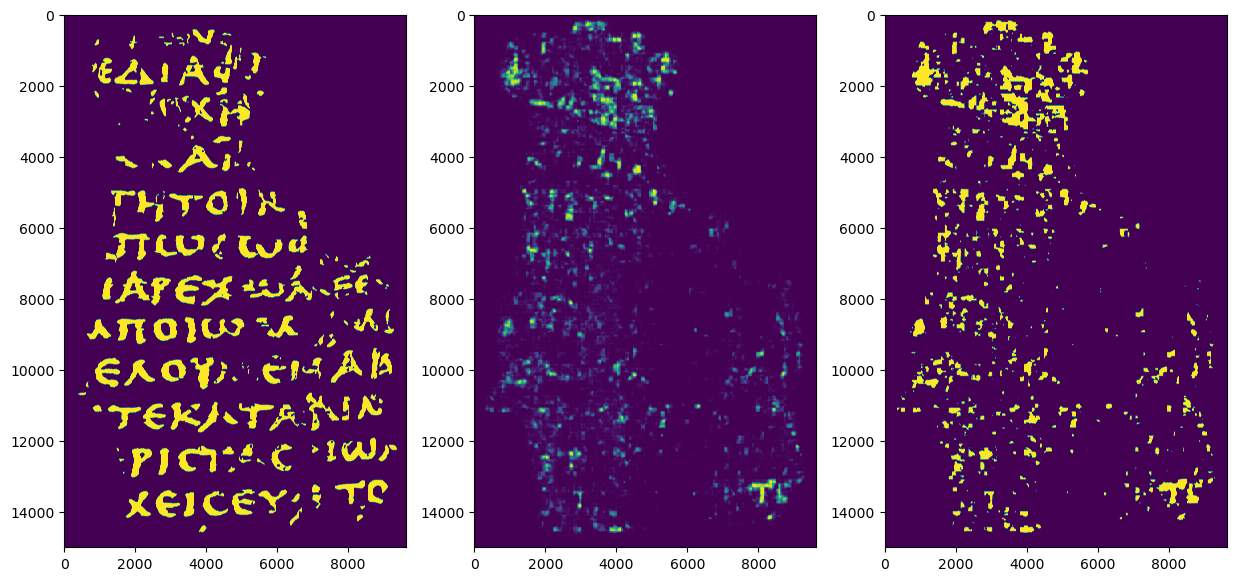

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.27073687e+08, 5.50011100e+06, 2.75370000e+06, 1.78911000e+06,
        1.27838200e+06, 9.55537000e+05, 7.73376000e+05, 6.58447000e+05,
        5.65670000e+05, 4.98655000e+05, 4.28266000e+05, 3.75282000e+05,
        3.23063000e+05, 2.77966000e+05, 2.47213000e+05, 2.53693000e+05,
        2.35514000e+05, 2.25709000e+05, 2.29696000e+05, 1.13979000e+05]),
 array([6.69847509e-06, 4.94649947e-02, 9.89232909e-02, 1.48381587e-01,
        1.97839883e-01, 2.47298179e-01, 2.96756476e-01, 3.46214772e-01,
        3.95673068e-01, 4.45131364e-01, 4.94589661e-01, 5.44047957e-01,
        5.93506253e-01, 6.42964549e-01, 6.92422845e-01, 7.41881142e-01,
        7.91339438e-01, 8.40797734e-01, 8.90256030e-01, 9.39714326e-01,
        9.89172623e-01]),
 <BarContainer object of 20 artists>)

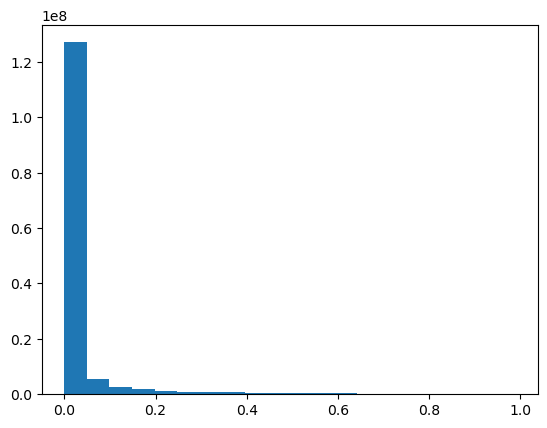

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000